In [128]:
setwd("C:/Users/User/Documents")
source("Meus Arquivos/Códigos/Funções.r")

In [107]:
options(warn = -1, scipen = 999)
suppressPackageStartupMessages({
    library(dplyr)
    library(tidyr)
    library(ggplot2)
    library(tidyquant)
    library(pracma)
    library(BatchGetSymbols)
})

In [150]:
#Estipule os parâmetros para calcular os desvios-padrão e os retornos médios (diários e anuais)
acoes <- c("^BVSP","ITUB4.SA","MULT3.SA",
           "VALE3.SA","BBDC4.SA","ABEV3.SA",
           "TRPL4.SA","WEGE3.SA","SUZB3.SA",
           "JBSS3.SA")
retornos_d <- tq_get(acoes, from = "2013-01-01") %>%
  group_by(symbol) %>%
  tq_transmute(select = close, mutate_fun= periodReturn, period = "daily") %>%
  spread(key = symbol, value = daily.returns) %>%
  na.omit

In [151]:
head(retornos_d)

date,^BVSP,ABEV3.SA,BBDC4.SA,ITUB4.SA,JBSS3.SA,MULT3.SA,SUZB3.SA,TRPL4.SA,VALE3.SA,WEGE3.SA
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2013-01-02,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0,0.000000000,0.000000000,0.00000000
2013-01-03,0.012182254,0.017731507,0.059183564,0.029872295,0.009771987,-0.006166437,0,0.005970300,-0.017006803,0.04477601
2013-01-04,-0.012462092,-0.016487082,-0.016791200,-0.005912475,0.030645161,0.004866145,0,0.050445175,-0.015455549,-0.01190473
2013-01-07,-0.009436527,0.011532311,-0.005068205,-0.016996876,-0.043818466,-0.015193625,0,-0.005932466,-0.019681350,-0.01204816
2013-01-08,-0.012997917,-0.001175344,0.003488285,0.004031544,0.000000000,0.000000000,0,-0.043762853,-0.007887237,-0.04006892
2013-01-09,0.007377961,0.015409236,0.012823387,0.016074092,0.018003273,0.005084945,0,0.010402056,0.004577283,0.00762248


In [152]:
cova <- cov(retornos_d[,-1])*252
media <- colMeans(retornos_d[,-1])*252
sd_d <- sqrt(diag(cova))

In [154]:
#Nº de simulações de carteiras a se fazer
n_sim <- 400000
pesos <- pesos_carteira(n_acoes = length(acoes), n_sim = n_sim, short = F)

In [155]:
start <- Sys.time()
riscos <- apply(pesos, 2, portfolio_sd_t, cov = cova)
retornos <- apply(pesos, 2, portfolio_return, returns = media)
end <- Sys.time()
end-start

Time difference of 17.87196 secs

In [156]:
#Sharpe
tx_livre_risco <- 0.02
data <- matrix(0, nrow = 3, ncol = n_sim)
data[1,] <- retornos
data[2,] <- riscos
data[3,] <- (retornos-tx_livre_risco)/riscos
rownames(data) <- c("Retornos", "Riscos","Sharpe")

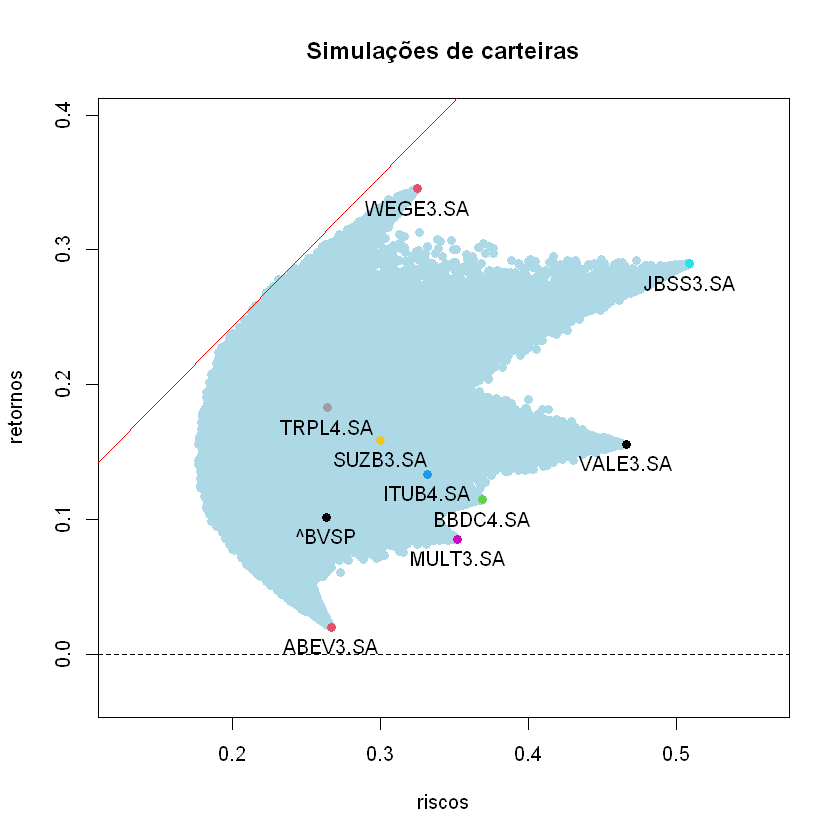

In [157]:
plot(riscos, retornos, pch = 16, col = "lightblue",xlim = c(min(riscos)-0.05, max(sd_d)+0.05),
    ylim = c(min(c(media, retornos))-0.05, max(c(media, retornos))+0.05), main = "Simulações de carteiras")
points(x = sd_d, y = media, col = 1:length(acoes), pch = 16)
text(x = sd_d, y = media, labels = sort(acoes), pos = 1)
abline(a = tx_livre_risco, b = max(data[3,]), col = "red")
abline(h = 0,v = 0, lty = 2)

In [158]:
sharpe <- max(data[3,])
names(sharpe) <- "Sharpe Máximo"
Ret_max <- max(data[1,])
names(Ret_max) <- "Retorno Máximo"
sd_min <- min(data[2,])
names(sd_min) <- "Risco Mínimo"
sharpe
Ret_max
sd_min

Sharpe Máximo 
     1.116005

Retorno Máximo 
     0.3453565

Risco Mínimo 
   0.1768467

In [159]:
#Somente ver a linha que tem o maior sharpe
positivo <- data[3,] == sharpe
show(data[,positivo])

 Retornos    Riscos    Sharpe 
0.2778627 0.2310588 1.1160047 


In [160]:
#Pesos em % da melhor carteira
pesos_efi <- round(pesos[,positivo],3)
names(pesos_efi) <- sort(acoes)
print(pesos_efi)

   ^BVSP ABEV3.SA BBDC4.SA ITUB4.SA JBSS3.SA MULT3.SA SUZB3.SA TRPL4.SA 
   0.003    0.000    0.023    0.007    0.066    0.001    0.104    0.226 
VALE3.SA WEGE3.SA 
   0.001    0.570 


In [161]:
#Carteira eficiente com arredondamento de 3 casas decimais
pesos_ef <- round(pesos[,positivo],3)
risco_ef <- portfolio_sd_t(cov = cova, pesos = pesos_ef)
ret_ef <- portfolio_return(returns = media, weight = pesos_ef)
cart_ef <- data.frame(Risco = risco_ef, Retorno = ret_ef, Sharpe = (ret_ef-tx_livre_risco)/risco_ef)
cart_ef

Risco,Retorno,Sharpe
<dbl>,<dbl>,<dbl>
0.2313002,0.2780032,1.115447
